# Few-Shot Learning Email Classification with Pre-Trained Word2Vec Embeddings

In [ ]:
import pandas as pd
import numpy as np
from random import seed
from random import sample

seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial

# from nltk.corpus import stopwords
import spacy
import en_core_web_sm

In [ ]:
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving emaildataset.csv to emaildataset.csv


In [ ]:
df = pd.read_csv("./emaildataset.csv", usecols = ['Subject','Body', 'Class'])
df.head()

,Subject,Body,Class
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",General
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending


In [ ]:
nlp_ = en_core_web_sm.load()

In [ ]:
nlp = spacy.load('en')

In [ ]:
my_stop = ["'d", "'ll", "'m", "'re", "'s", "'ve",'a','cc','subject','http', 'gbp', 'usd', 'eur', 'inr', 'cad', 'thanks', "acc", "id", 'account', 'regards', 'hi', 'hello', 'thank you', 'greetings', 'about','above', 'across','after','afterwards','against','alone','along','already','also','although','am','among', 'amongst','amount','an','and','another','any','anyhow','anyone','anything','anyway','anywhere','are','around','as', 'at','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','below', 'beside','besides','between','both','bottom','but','by','ca','call','can','could','did', 'do', 'does', 'doing', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'every', 'everyone', 'everything', 'everywhere', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'made', 'make', 'many', 'may', 'me', 'meanwhile', 'might', 'mine', 'more', 'moreover', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'quite', 'rather', 're', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'under', 'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'via', 'was', 'we', 'well', 'were', 'whatever', 'whence', 'whenever', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'whoever', 'whole', 'whom', 'whose', 'will', 'with', 'within', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', '‘d', '‘ll', '‘m', '‘re', '‘s', '‘ve', '’d', '’ll', '’m', '’re', '’s', '’ve']


In [ ]:
def get_only_chars(text):    
    # text = text.replace("’", "")
    # text = text.replace("-", " ") #replace hyphens with spaces
    # text = text.replace("\t", " ")
    # text = text.replace("\n", " ")
    # text = text.lower()
    # # return clean_line

    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = " ".join([i for i in text.lower().split()])
    # print(text)
    text = " ".join(token for token in text.split() if token not in my_stop)

    doc = nlp(text)
    
    normalized = " ".join(token.lemma_ for token in doc)
    
    doc = " ".join(token.orth_ for token in nlp(normalized) if not token.is_punct | token.is_space)
    return doc

In [ ]:
# subj, body to text

for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text'] = (df['Subject'] + " " + df['Body'])

In [ ]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).split()])
    except AttributeError:
        return None  # or some other value

df['Text'] = df['Text'].apply(converter)

In [ ]:
text_clean=[]

for i in range(df.shape[0]):
    text_clean.append(get_only_chars(df.loc[i]['Text']))

In [ ]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))

In [ ]:
# print(df.Text[0])

In [ ]:
df = df.drop_duplicates('Text')

In [ ]:
df.head()

,Subject,Body,Class,Text
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,transaction unresolve sorry inform partial pay...
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,order new cheque book good morning want place ...
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,require money acquire transaction process info...
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,ask detail transaction request kindly send sta...
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,partial payment transaction day status transac...


In [ ]:
# set the by default to :

num_classes = 5 # the number of classes we consider (since the dataset has many classes)
sample_size = 5 # the number of labeled sampled we’ll require from the user

In [ ]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
# classes = df['Class'].values

# classes = classes.reshape(-1, 1)
# Y = le.fit_transform(classes)
df['Class'] = le.fit_transform(df['Class'])

In [ ]:
df.head()
# df.shape

,Subject,Body,Class,Text
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,3,transaction unresolve sorry inform partial pay...
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",2,order new cheque book good morning want place ...
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,4,require money acquire transaction process info...
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,5,ask detail transaction request kindly send sta...
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,3,partial payment transaction day status transac...


In [ ]:
df['Class'] = df['Class'].apply(lambda x : x + 1)

In [ ]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes):

    df_1 = df[(df["Class"] < num_classes+1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Class"] == np.unique(df_1['Class'])[0]].sample(sample_size)

    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Class"] == np.unique(df_1['Class'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]
    # return test
    return train, test

In [ ]:
# test = gen_sample(sample_size, num_classes)
# test.head(30)

In [ ]:
# Apply that to the dataframe :

train, test = gen_sample(sample_size, num_classes)

X_train = train['Text']
y_train = train['Class'].values
X_test = test['Text']
y_test = test['Class'].values

In [ ]:
# train.head(20)
print(train.values[2])

['Received full payment for transaction no. 338874'
 'Hey, I am writing in reference to the transaction 338874 . I was granted the aforementioned amount within the deadline. Sincere gratitude for such a quick response. Kind regards'
 1
 'receive full payment transaction hey write reference transaction grant aforementioned deadline sincere gratitude quick response kind']


In [ ]:
# test.head(20)

In [ ]:
# print(X_train)

In [ ]:
print(X_train.shape)

(25,)


In [ ]:
# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):

    """
    Mean embedding vector
    """

    def preprocess_text(raw_text, model=model):

        """ 
        Excluding unknown words and get corresponding token
        """

        raw_text = raw_text.split()

        return list(filter(lambda x: x in model.vocab, raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)

    return np.array(text_vector)

In [ ]:
# Apply this to both the train and the test :

X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

In [ ]:
type(X_train_mean)

pandas.core.frame.DataFrame

In [ ]:
# Use cosine similarity to find closest class

def classify_txt(txt, mean_embedding):

    best_dist = 1
    best_label = -1

    for cl in range(num_classes):

        dist = spatial.distance.cosine(transform_sentence(txt, model), mean_embedding[cl])

        if dist < best_dist :
            best_dist = dist
            best_label = cl + 1 # not cl?

    return best_label

In [ ]:
# Process text and predict on the test set

def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    mean_embedding = {}
    for cl in range(num_classes):
        mean_embedding[cl] = np.mean((X_train_mean[y_train == cl + 1]), axis=0)

    y_pred = [classify_txt(t, mean_embedding) for t in test['Text'].values]

    return accuracy_score(y_pred, y_test)

In [ ]:
# Now, we will iterate on the number of classes (between 2 and 7) and the number of samples (between 1 and 30). 
# We will consider that labeling more than 30 training examples per class is too long.

# all_accuracy = {2:[],3:[],4:[],5:[],6:[],7:[]}
all_accuracy = {5:[],6:[],7:[]}

for num_samples in range(1,30):
    for num_cl in range(5, 7):
        all_accuracy[num_cl].append(return_score(num_samples,num_cl))

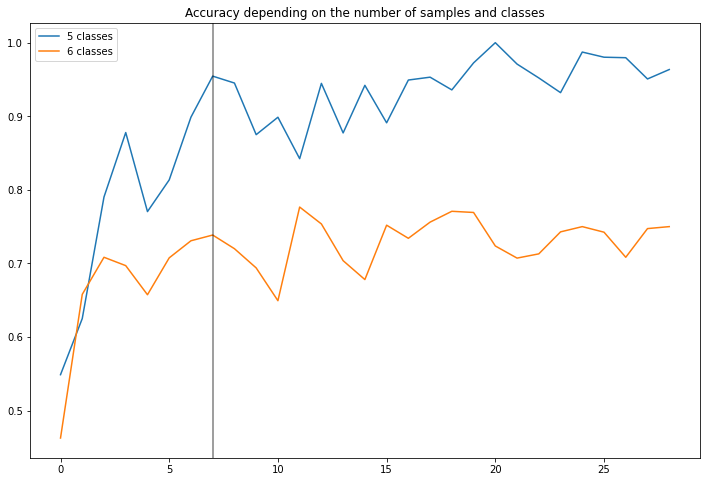

In [ ]:
# plotting accuracy for each no. of class, depending on the number of train examples :

plt.figure(figsize=(12,8))
# plt.plot(all_accuracy[2], label="2 classes")
# plt.plot(all_accuracy[3], label="3 classes")
# plt.plot(all_accuracy[4], label="4 classes")
plt.plot(all_accuracy[5], label="5 classes")
plt.plot(all_accuracy[6], label="6 classes")
plt.axvline(7, c='black', alpha=0.5)
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

## Pre-trained Word2Vec and ML algorithms

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm, tree
from sklearn.naive_bayes import MultinomialNB
import xgboost
from sklearn.model_selection import cross_val_score

In [ ]:
# def intermediate(sample_size, num_classes):
#   train, test = gen_sample(sample_size, num_classes)

#     X_train = train['Text']
#     y_train = train['Class'].values
#     X_test = test['Text']
#     y_test = test['Class'].values

#     X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
#     X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

#     X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
#     X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

#     return X_train_mean, X_test_mean, y_train, y_test

In [ ]:
# X_train_mean, X_test_mean, y_train, y_test = intermediate(sample_size, num_classes)

In [ ]:
def return_score_knn(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # K nearest neighbours algorithm (lazy learner)
    clf = KNeighborsClassifier(n_neighbors=sample_size, p=2) # euclidean distance
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [ ]:
def return_score_radius(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # Radius neighbours
    clf2 = RadiusNeighborsClassifier(radius=1.0, outlier_label='most_frequent')
    clf2.fit(X_train_mean, y_train)

    y_pred = clf2.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [ ]:
# def return_score_nb(sample_size, num_classes):

#     train, test = gen_sample(sample_size, num_classes)

#     X_train = train['Text']
#     y_train = train['Class'].values
#     X_test = test['Text']
#     y_test = test['Class'].values

#     X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
#     X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

#     X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
#     X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

#     # Naive Bayes (eager learner)
#     clf = MultinomialNB()
#     clf.fit(X_train_mean, y_train)

#     y_pred = clf.predict(X_test_mean)

#     return accuracy_score(y_pred, y_test)

In [ ]:
def return_score_svc(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # SVC
    clf = svm.SVC()
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [ ]:
def return_score_rf(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # Random forest classifier
    clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [ ]:
def return_score_linsvc(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # Linear SVC
    clf = LinearSVC()
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [ ]:
def return_score_xgb(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # XG Boost
    clf = xgboost.XGBClassifier()
    clf.fit(X_train_mean, y_train)

    if not os.path.exists('./pkl_objects'):
        os.mkdir('./pkl_objects')
    
    joblib.dump(le, './pkl_objects/labelencoder.pkl')
    joblib.dump(clf, './pkl_objects/clf.pkl')
    # drive.mount('/content/drive')
    # DATA_PATH = "/content/drive/Data"
    # infile = open(DATA_PATH+'/labelencoder.pickle','rb')
    # le = pickle.load(infile)
    # infile2 = open(DATA_PATH+'/model_xgb.pickle','rb')
    # clf = pickle.load(infile2)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [ ]:
def return_score_dt(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    # Decision tree
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

## Comparison of accuracies

In [ ]:
all_accuracy_knn = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_knn[num_cl].append(return_score_knn(num_samples,num_cl))

In [ ]:
all_accuracy_radius = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_radius[num_cl].append(return_score_radius(num_samples,num_cl))

In [ ]:
# all_accuracy_nb = {2:[],3:[],4:[],5:[],6:[],7:[]}

# for num_samples in range(1,30):

#     for num_cl in range(2, 7):

#         all_accuracy_nb[num_cl].append(return_score_nb(num_samples,num_cl))

In [ ]:
all_accuracy_svc = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_svc[num_cl].append(return_score_svc(num_samples,num_cl))

In [ ]:
all_accuracy_rf = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_rf[num_cl].append(return_score_rf(num_samples,num_cl))

In [ ]:
all_accuracy_linsvc = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_linsvc[num_cl].append(return_score_linsvc(num_samples,num_cl))

In [ ]:
all_accuracy_xgb = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_xgb[num_cl].append(return_score_xgb(num_samples,num_cl))

In [ ]:
all_accuracy_dt = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_dt[num_cl].append(return_score_dt(num_samples,num_cl))

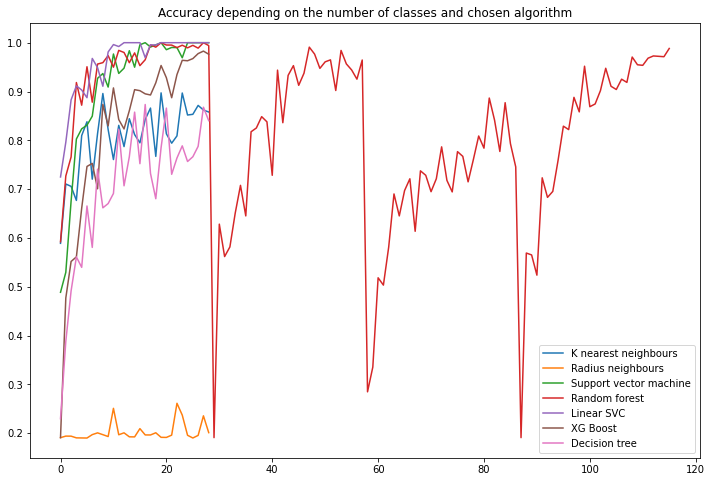

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_knn[5], label="K nearest neighbours")
plt.plot(all_accuracy_radius[5], label="Radius neighbours")
# plt.plot(all_accuracy_nb[5], label="Multinomial naive bayes")
plt.plot(all_accuracy_svc[5], label="Support vector machine")
plt.plot(all_accuracy_rf[5], label="Random forest")
plt.plot(all_accuracy_linsvc[5], label="Linear SVC")
plt.plot(all_accuracy_xgb[5], label="XG Boost")
plt.plot(all_accuracy_dt[5], label="Decision tree")

plt.title("Accuracy depending on the number of classes and chosen algorithm")
plt.legend()
plt.show()

## Summary

In [ ]:
# df_results = pd.DataFrame({
#     'Nb Classes':[2,3,4,5], 
#     'min K-NN':[min(all_accuracy_knn[2]), 
#         min(all_accuracy_knn[3]), 
#         min(all_accuracy_knn[4]), 
#         min(all_accuracy_knn[5])],
#     'min Cosine':[min(all_accuracy[2]), 
#         min(all_accuracy[3]), 
#         min(all_accuracy[4]), 
#         min(all_accuracy[5])],
#     'mean K-NN':[np.mean(all_accuracy_knn[2]), 
#         np.mean(all_accuracy_knn[3]), 
#         np.mean(all_accuracy_knn[4]), 
#         np.mean(all_accuracy_knn[5])],
#     'mean Cosine':[np.mean(all_accuracy[2]), 
#         np.mean(all_accuracy[3]), 
#         np.mean(all_accuracy[4]), 
#         np.mean(all_accuracy[5])],
#     'max K-NN':[max(all_accuracy_knn[2]), 
#         max(all_accuracy_knn[3]), 
#         max(all_accuracy_knn[4]), 
#         max(all_accuracy_knn[5])],
#     'max Cosine':[max(all_accuracy[2]), 
#         max(all_accuracy[3]), 
#         max(all_accuracy[4]), 
#         max(all_accuracy[5])]
#     })

In [ ]:
df_results = pd.DataFrame({
    
    'Nb Classes':[2, 3, 4, 5, 6], 

    'mean K-NN':[np.mean(all_accuracy_knn[2]), 
        np.mean(all_accuracy_knn[3]), 
        np.mean(all_accuracy_knn[4]), 
        np.mean(all_accuracy_knn[5]),
        np.mean(all_accuracy_knn[6])],
    'max K-NN':[max(all_accuracy_knn[2]), 
        max(all_accuracy_knn[3]), 
        max(all_accuracy_knn[4]), 
        max(all_accuracy_knn[5]),
        max(all_accuracy_knn[6])],

    'mean Cosine':[np.mean(all_accuracy[2]), 
        np.mean(all_accuracy[3]), 
        np.mean(all_accuracy[4]), 
        np.mean(all_accuracy[5]),
        np.mean(all_accuracy[6])], 
    'max Cosine':[max(all_accuracy[2]), 
        max(all_accuracy[3]), 
        max(all_accuracy[4]), 
        max(all_accuracy[5]),
        max(all_accuracy[6])],

    'mean R-N':[np.mean(all_accuracy_radius[2]), 
        np.mean(all_accuracy_radius[3]), 
        np.mean(all_accuracy_radius[4]), 
        np.mean(all_accuracy_radius[5]),
        np.mean(all_accuracy_radius[6])],
    'max R-N':[max(all_accuracy_radius[2]), 
        max(all_accuracy_radius[3]), 
        max(all_accuracy_radius[4]), 
        max(all_accuracy_radius[5]),
        max(all_accuracy_radius[6])],

    # 'mean Naive Bayes':[np.mean(all_accuracy_nb[2]), 
    #     np.mean(all_accuracy_nb[3]), 
    #     np.mean(all_accuracy_nb[4]), 
    #     np.mean(all_accuracy_nb[5]),
    #     np.mean(all_accuracy_nb[6])],
    # 'max Naive Bayes':[max(all_accuracy_nb[2]), 
    #     max(all_accuracy_nb[3]), 
    #     max(all_accuracy_nb[4]), 
    #     max(all_accuracy_nb[5]),
    #     max(all_accuracy_nb[6])],

    'mean SVM':[np.mean(all_accuracy_svc[2]), 
        np.mean(all_accuracy_svc[3]), 
        np.mean(all_accuracy_svc[4]), 
        np.mean(all_accuracy_svc[5]),
        np.mean(all_accuracy_svc[6])],
    'max SVM':[max(all_accuracy_svc[2]), 
        max(all_accuracy_svc[3]), 
        max(all_accuracy_svc[4]), 
        max(all_accuracy_svc[5]),
        max(all_accuracy_svc[6])],

    'mean Linear SVC':[np.mean(all_accuracy_linsvc[2]), 
        np.mean(all_accuracy_linsvc[3]), 
        np.mean(all_accuracy_linsvc[4]), 
        np.mean(all_accuracy_linsvc[5]),
        np.mean(all_accuracy_linsvc[6])],
    'max Linear SVC':[max(all_accuracy_linsvc[2]), 
        max(all_accuracy_linsvc[3]), 
        max(all_accuracy_linsvc[4]), 
        max(all_accuracy_linsvc[5]),
        max(all_accuracy_linsvc[6])],

    'mean XG Boost':[np.mean(all_accuracy_xgb[2]), 
        np.mean(all_accuracy_xgb[3]), 
        np.mean(all_accuracy_xgb[4]), 
        np.mean(all_accuracy_xgb[5]),
        np.mean(all_accuracy_xgb[6])],
    'max XG Boost':[max(all_accuracy_xgb[2]), 
        max(all_accuracy_xgb[3]), 
        max(all_accuracy_xgb[4]), 
        max(all_accuracy_xgb[5]),
        max(all_accuracy_xgb[6])],

    'mean Decision Tree':[np.mean(all_accuracy_dt[2]), 
        np.mean(all_accuracy_dt[3]), 
        np.mean(all_accuracy_dt[4]), 
        np.mean(all_accuracy_dt[5]),
        np.mean(all_accuracy_dt[6])],
    'max Decision Tree':[max(all_accuracy_dt[2]), 
        max(all_accuracy_dt[3]), 
        max(all_accuracy_dt[4]), 
        max(all_accuracy_dt[5]),
        max(all_accuracy_dt[6])],

    'mean Random Forest':[np.mean(all_accuracy_rf[2]), 
        np.mean(all_accuracy_rf[3]), 
        np.mean(all_accuracy_rf[4]), 
        np.mean(all_accuracy_rf[5]),
        np.mean(all_accuracy_rf[6])],
    'max Random Forest':[max(all_accuracy_rf[2]), 
        max(all_accuracy_rf[3]), 
        max(all_accuracy_rf[4]), 
        max(all_accuracy_rf[5]),
        max(all_accuracy_rf[6])]
    })

In [ ]:
df_results

,Nb Classes,mean K-NN,max K-NN,mean Cosine,max Cosine,mean R-N,max R-N,mean SVM,max SVM,mean Linear SVC,max Linear SVC,mean XG Boost,max XG Boost,mean Decision Tree,max Decision Tree,mean Random Forest,max Random Forest
0,2,0.907575,1.000000,0.961612,1.000000,0.605373,0.771930,0.962001,1.0,0.966439,1.0,0.883083,1.000000,0.867971,0.985915,0.884763,1.000000
1,3,0.789893,0.942149,0.541142,0.587209,0.359022,0.454545,0.941706,1.0,0.985794,1.0,0.832425,0.991304,0.823886,0.966942,0.871878,1.000000
2,4,0.811991,0.930851,0.348279,0.392857,0.235186,0.309524,0.951213,1.0,0.971137,1.0,0.844280,0.989130,0.750527,0.891026,0.850797,1.000000
3,5,0.806711,0.897196,0.312082,0.340136,0.202440,0.261307,0.913296,1.0,0.960796,1.0,0.821535,0.982759,0.702252,0.873362,0.824265,1.000000
4,6,0.707773,0.832090,0.245847,0.271978,0.184478,0.232000,0.917646,1.0,0.952775,1.0,0.819872,0.963636,0.674658,0.836449,0.807507,0.991597
